## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Loading Datasets

_EL NINO_

In [3]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:,1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

29.2
1       0.000000
2       0.114286
3       0.028571
4       0.100000
5       0.100000
          ...   
1629   -0.242857
1630   -0.071429
1631    0.057143
1632   -0.085714
1633   -0.014286
Name: SST1, Length: 1633, dtype: float64
2       1.632653e-02
3      -1.224490e-02
4       1.020408e-02
5      -7.335402e-17
6      -1.224490e-02
            ...     
1629   -2.857143e-02
1630    2.448980e-02
1631    1.836735e-02
1632   -2.040816e-02
1633    1.020408e-02
Name: SST1, Length: 1632, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.000000
1       0.114286
2       0.028571
3       0.100000
4       0.100000
          ...   
1628   -0.242857
1629   -0.071429
1630    0.057143
1631   -0.085714
1632   -0.014286
Name: SST1, Length: 1633, dtype: float64
0       1.632653e-02
1      -1.224490e-02
2       1.020408e-02
3      -7.335402e-17
4      -1.224490e-02
            ...     
1627   -2.857143e-02
1628    2.448980e-02
1629    1.836735e-02
1630   -2.040816e-02
1631    1.020408e-02
Name: SST1, Length: 1632, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(1633,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lorrenz Equation_)

<AxesSubplot:>

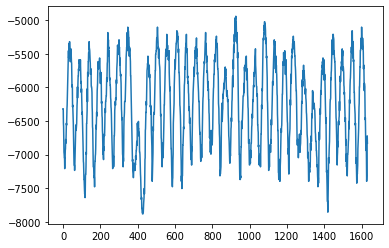

In [7]:
s=10
r=28
L = df.iloc[:, 2] + df.iloc[:, 1]*(1 + s) - df.iloc[:, 0] * s * (r - 1)
L.plot()

## Preprocessing the data into supervised learning

In [8]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [9]:
dat = Supervised(df.values, n_in = 10, n_out = 52)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       ...
       'var3(t+48)', 'var1(t+49)', 'var2(t+49)', 'var3(t+49)', 'var1(t+50)',
       'var2(t+50)', 'var3(t+50)', 'var1(t+51)', 'var2(t+51)', 'var3(t+51)'],
      dtype='object', length=186)

In [10]:
data = Supervised(df.values, n_in = 10, n_out = 52)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...  var3(t+48)  var1(t+49)  \
10       25.9       26.1       26.1       26.7  ...   -0.010204        26.5   
11       26.1       26.1       26.7       26.1  ...    0.000000        26.5   
12       26.1       26.7       26.1       26.1  ...    0.006122        26.5   
13       26.7       26.1       26.1       25.7  ...   -0.010204        26.8   
14       26.1       26.1       25.7       25.6  ...   -0.004082        26.6   

    var2(t+49)    var3(t+49)  var1(t+50)  var2(t+50)    var3(t+50)  \
10    0.000000  

## Train and Test Split

In [11]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1256, 1, 157) (1256, 9) (315, 1, 157) (315, 9)


## Defining the Physical Loss

In [12]:
s = tf.Variable(10, name="sigma", trainable=True, dtype=tf.float32)
r = tf.Variable(28, name="rhow", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] + y_true[:, 1]*(1 + s) - y_true[:, 0] * s * (r - 1)), (y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] + (y_pred[1:-1]-y_pred[:-2])*(1 + s) - y_pred[:-2] * s * (r - 1)
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] + (y_real[1:-1]-y_real[:-2])*(1 + s) - y_real[:-2] * s * (r - 1)
    return(mean_absolute_error(pred, real))

## Model

In [13]:
s = tf.Variable(10, name="sigma", trainable=True, dtype=tf.float32)
r = tf.Variable(28, name="rhow", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square((y_pred[:, 2] + y_pred[:, 1]*(1 + s) - y_pred[:, 0] * s * (r - 1)))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
20/20 [==============================] - 2s 27ms/step - loss: 96.3853 - val_loss: 27.2706
Epoch 2/500
20/20 [==============================] - 0s 4ms/step - loss: 15.7474 - val_loss: 5.9380
Epoch 3/500
20/20 [==============================] - 0s 4ms/step - loss: 5.7191 - val_loss: 4.5982
Epoch 4/500
20/20 [==============================] - 0s 4ms/step - loss: 3.9975 - val_loss: 3.6614
Epoch 5/500
20/20 [==============================] - 0s 4ms/step - loss: 3.0623 - val_loss: 2.9841
Epoch 6/500
20/20 [==============================] - 0s 4ms/step - loss: 2.4649 - val_loss: 2.4377
Epoch 7/500
20/20 [==============================] - 0s 4ms/step - loss: 1.9981 - val_loss: 2.0156
Epoch 8/500
20/20 [==============================] - 0s 4ms/step - loss: 1.6378 - val_loss: 1.6830
Epoch 9/500
20/20 [==============================] - 0s 4ms/step - loss: 1.3615 - val_loss: 1.4216
Epoch 10/500
20/20 [==============================] - 0s 4ms/step - loss: 1.1509 - val_loss: 1.2169
Epoch

## Metrics

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

10/10 [==============================] - 1s 2ms/step
(315, 9)
(315, 157)
Test RMSE: 7.852
Test MAE: 7.479
